# Train the model for the 'Intelligent Hydroponic System' using TensorFlow Lite to be run on the microcontroller
 
The training of the neural model happens in this notebook, after fetching the data from the Arduino’s serial monitor, the data-set is made by data collected from the serial monitor of the Arduino IDE by manually sliding the potentiometer to control the pump speed to achieve the desired pH value. The data set is stored in a CSV file which is used for training the neural Model.

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by the pH sensor to control the speed of the pump. This will result in a model that can take a pH value, `x`, and predict its corresponding pump speed, `y`.

**Training is much faster using GPU acceleration.** Before you proceed, ensure you are using a GPU runtime by going to **Runtime -> Change runtime type** and set **Hardware accelerator: GPU**.

## Configure Defaults

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'

if not os.path.isdir(MODELS_DIR):
  os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model.pb'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [2]:
# ! pip install -q tensorflow==2

Set Seed for Repeatable Results

In [3]:
# Set a "seed" value, so we get the same random numbers each time we run this
# notebook for reproducible results.
# Numpy is a math library
import numpy as np
np.random.seed(1) # numpy seed
# TensorFlow is an open source machine learning library
import tensorflow as tf
tf.random.set_seed(1) # tensorflow global random seed

Import libraries

In [4]:
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
import csv

# Read the dataset file from the google drive

After importing all the important libraries, the data is read from the dataset file using a custom method, read-file.  All the columns in the data set are stored in individual arrays.  Then, (X, Y) pairs are formed to prepare the data for training. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
corpus_name = "tinyML"
corpus = os.path.join("/content/drive/My Drive/Colab Notebooks/data", corpus_name)

In [7]:
import csv
csvfile = os.path.join(corpus, "ph_dataset.csv")
feature_names = ['Time (in milliseconds)','Pump speed','Water level (in mm)','pH']
# time_array=[]
speed_array=[]
# water_level_array=[]
ph_array=[]
rows_array=[]
line_count = 0

def read_file():
  global line_count
  with open(csvfile, 'r', encoding='iso-8859-1') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    # rows_array.append(feature_names)
    for row in csv_reader:
          row_array=[]
          # row is a type list 
          if line_count != 0:
            for field in row:
              row_array.append(field)
            rows_array.append(row_array) 
          line_count += 1

    # becuase first line a column names
    line_count -= 1

    print(f'Processed {line_count} lines.')
    for row in rows_array:      
      # time_array.append(float(row[0]))
      speed_array.append(float(row[0]))
      # water_level_array.append(float(row[2]))
      ph_array.append(float(row[1]))

read_file()

# print(rows_array)
# print(time_array)
print(speed_array)
# print(water_level_array)
print(ph_array)

Processed 1000 lines.
[20.0, 20.4, 20.8, 21.2, 21.6, 22.0, 22.4, 22.8, 23.2, 23.6, 24.0, 24.4, 24.8, 25.2, 25.6, 26.0, 26.4, 26.8, 27.2, 27.6, 28.0, 28.4, 28.8, 29.2, 29.6, 30.0, 30.4, 30.8, 31.2, 31.6, 32.0, 32.4, 32.8, 33.2, 33.6, 34.0, 34.4, 34.8, 35.2, 35.6, 36.0, 36.4, 36.8, 37.2, 37.6, 38.0, 38.4, 38.8, 39.2, 39.6, 40.0, 40.4, 40.8, 41.2, 41.6, 42.0, 42.4, 42.8, 43.2, 43.6, 44.0, 44.4, 44.8, 45.2, 45.6, 46.0, 46.4, 46.8, 47.2, 47.6, 48.0, 48.4, 48.8, 49.2, 49.6, 50.0, 50.4, 50.8, 51.2, 51.6, 52.0, 52.4, 52.8, 53.2, 53.6, 54.0, 54.4, 54.8, 55.2, 55.6, 56.0, 56.4, 56.8, 57.2, 57.6, 58.0, 58.4, 58.8, 59.2, 59.6, 60.0, 60.4, 60.8, 61.2, 61.6, 62.0, 62.4, 62.8, 63.2, 63.6, 64.0, 64.4, 64.8, 65.2, 65.6, 66.0, 66.4, 66.8, 67.2, 67.6, 68.0, 68.4, 68.8, 69.2, 69.6, 70.0, 70.4, 70.8, 71.2, 71.6, 72.0, 72.4, 72.8, 73.2, 73.6, 74.0, 74.4, 74.8, 75.2, 75.6, 76.0, 76.4, 76.8, 77.2, 77.6, 78.0, 78.4, 78.8, 79.2, 79.6, 80.0, 80.4, 80.8, 81.2, 81.6, 82.0, 82.4, 82.8, 83.2, 83.6, 84.0, 84.4, 84.8,

## Dataset

### 1. Generate Data


In [8]:
# Number of sample data points
SAMPLES = line_count

# FOR pH MONITORING
ph_array = np.array(ph_array, dtype=np.float32)
speed_array = np.array(speed_array, dtype=np.float32)

# Shuffle the values to guarantee they're not in order
xy=[]
for x, y in zip(ph_array, speed_array):
  xy.append([x,y])
np.random.shuffle(xy)

x_values=[]
y_values=[]
for pair in xy:
  x_values.append(pair[0])
  y_values.append(pair[1])


print(len(x_values))
print(len(y_values))
# print(x_values)
print(xy)


1000
1000
[[8.93, 34.65], [5.82, 18.9], [9.48, 37.4], [10.32, 49.6], [11.58, 87.4], [4.71, 0.0], [11.38, 81.4], [5.9, 22.5], [10.82, 64.6], [13.51, 39.6], [9.54, 37.7], [12.58, 76.8], [4.32, 0.0], [10.55, 56.5], [4.29, 0.0], [12.67, 73.2], [12.96, 61.6], [13.94, 22.4], [8.0, 30.0], [9.04, 35.2], [6.98, 24.9], [9.28, 36.4], [8.02, 30.1], [8.98, 34.9], [9.67, 38.35], [12.81, 67.6], [12.92, 63.2], [7.53, 27.65], [8.11, 30.55], [10.26, 47.8], [4.9, 0.0], [6.82, 24.1], [6.56, 22.8], [9.06, 35.3], [9.96, 39.8], [11.26, 77.8], [13.22, 51.2], [6.79, 23.95], [7.56, 27.8], [7.86, 29.3], [5.28, 0.0], [7.09, 25.45], [13.1, 56.0], [12.99, 60.4], [13.06, 57.6], [8.23, 31.15], [8.63, 33.15], [13.59, 36.4], [9.47, 37.35], [4.05, 0.0], [6.87, 24.35], [13.66, 33.6], [7.61, 28.05], [13.65, 34.0], [12.52, 79.2], [9.45, 37.25], [5.15, 0.0], [7.23, 26.15], [9.14, 35.7], [7.15, 25.75], [10.93, 67.9], [11.62, 88.6], [10.05, 41.5], [6.66, 23.3], [5.78, 17.1], [5.88, 21.6], [9.36, 36.8], [5.84, 19.8], [8.72, 33

#Plot

The data is plotted to visualize its nature.

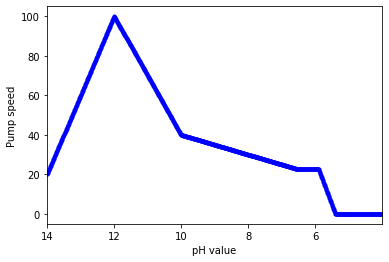

In [9]:
# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.xlabel('pH value')
plt.ylabel('Pump speed')
plt.xlim(max(x_values), min(x_values))
plt.show()

### 3. Split the Data

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 

It is made sure that the total number of samples is equal to their sum, to be on a safer side.  All the sections of the datasets are individually plotted on the same graph to ensure the random assignment of data to each category. 

The following code will split our data and then plots each set as a different color:


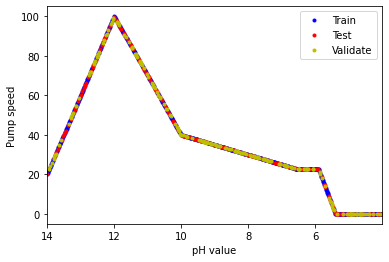

In [10]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.xlabel('pH value')
plt.ylabel('Pump speed')
plt.xlim(max(x_values), min(x_values))
plt.legend()
plt.show()


## Training a Larger Model

### 1. Design the Model
To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with 16 neurons in the first layer and an additional layer of 16 neurons in the middle:

In [11]:
model_2 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.

model_2.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))
model_2.add(keras.layers.Dense(64, activation='relu', input_shape=(1,)))
model_2.add(keras.layers.Dense(128, activation='relu', input_shape=(1,)))
model_2.add(keras.layers.Dense(64, activation='relu', input_shape=(1,)))
model_2.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_2.add(keras.layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

### 2. Train the Model ###

We'll now train the new model.

In [12]:
history_2 = model_2.fit(x_train, y_train, epochs=1650, batch_size=64,
                    validation_data=(x_validate, y_validate))

Epoch 1/1650
10/10 [==============================] - 1s 27ms/step - loss: 2158.9995 - mae: 38.1873 - val_loss: 2164.2998 - val_mae: 37.8148
Epoch 2/1650
10/10 [==============================] - 0s 5ms/step - loss: 2023.5975 - mae: 36.8727 - val_loss: 1990.8788 - val_mae: 36.1082
Epoch 3/1650
10/10 [==============================] - 0s 5ms/step - loss: 1800.3679 - mae: 34.5099 - val_loss: 1668.5142 - val_mae: 32.7187
Epoch 4/1650
10/10 [==============================] - 0s 5ms/step - loss: 1373.2554 - mae: 29.5709 - val_loss: 1092.8291 - val_mae: 25.6250
Epoch 5/1650
10/10 [==============================] - 0s 5ms/step - loss: 734.4600 - mae: 20.2685 - val_loss: 452.9010 - val_mae: 14.4724
Epoch 6/1650
10/10 [==============================] - 0s 4ms/step - loss: 382.6938 - mae: 15.4688 - val_loss: 422.8957 - val_mae: 18.2831
Epoch 7/1650
10/10 [==============================] - 0s 7ms/step - loss: 398.9903 - mae: 17.2245 - val_loss: 364.2645 - val_mae: 15.7185
Epoch 8/1650
10/10 [=====

### 3. Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 500/500
600/600 [==============================] - 0s 51us/sample - loss: 0.0118 - mae: 0.0873 - val_loss: 0.0105 - val_mae: 0.0832
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.01, and validation MAE has dropped from 0.33 to 0.08.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

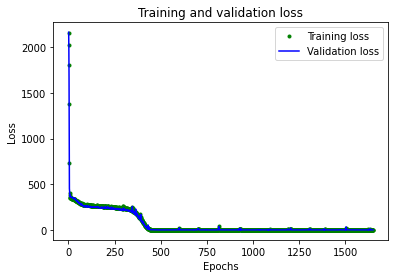

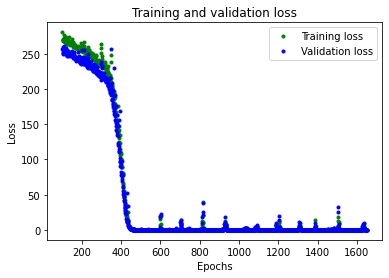

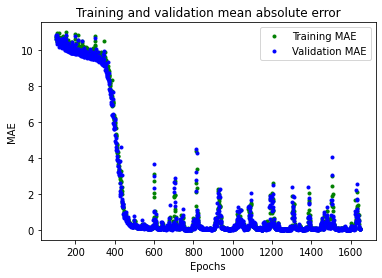

In [13]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.clf()

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Great results! From these graphs, we can see several exciting things:

*   Our network has reached its peak accuracy much more quickly (within 200 epochs instead of 500)
*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


7/7 [==============================] - 0s 2ms/step - loss: 0.0120 - mae: 0.0754


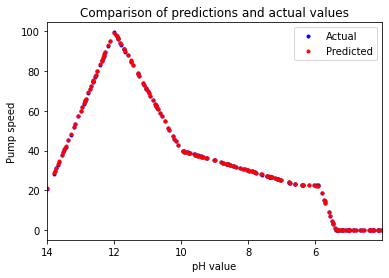

In [14]:
# Calculate and print the loss on our test dataset
loss = model_2.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model_2.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.xlabel('pH value')
plt.ylabel('Pump speed')
plt.xlim(max(x_values), min(x_values))
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.


## Generate a TensorFlow Lite Model

### 1. Generate Models with or without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of models is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) while converting the model. It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

*Note: Currently, TFLite Converter produces TFlite models with float interfaces (input and output ops are always float). This is a blocker for users who require TFlite models with pure int8 or uint8 inputs/outputs. Refer to https://github.com/tensorflow/tensorflow/issues/38285*

In the following cell, we'll convert the model twice: once with quantization, once without.

In [15]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
model_no_quant_tflite = converter.convert()

# # Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(int(SAMPLES/2)):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization (except inputs/outputs which are always float)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpkc6y9b4p/assets
INFO:tensorflow:Assets written to: /tmp/tmp0a4_f2yt/assets


INFO:tensorflow:Assets written to: /tmp/tmp0a4_f2yt/assets


22240

### 2. Compare Model Sizes

In [16]:
import os
model_no_quant_size = os.path.getsize(MODEL_NO_QUANT_TFLITE)
print("Model is %d bytes" % model_no_quant_size)
model_size = os.path.getsize(MODEL_TFLITE)
print("Quantized model is %d bytes" % model_size)
difference = model_no_quant_size - model_size
print("Difference is %d bytes" % difference)

Model is 73548 bytes
Quantized model is 22240 bytes
Difference is 51308 bytes


Our quantized model is only 224 bytes smaller than the original version, which only a tiny reduction in size! At around 2.5 kilobytes, this model is already so small that the weights make up only a small fraction of the overall size, meaning quantization has little effect.

More complex models have many more weights, meaning the space saving from quantization will be much higher, approaching 4x for most sophisticated models.

Regardless, our quantized model will take less time to execute than the original version, which is important on a tiny microcontroller!

### 3. Test the Models

To prove these models are still accurate after conversion and quantization, we'll use both of them to make predictions and compare these against our test results:

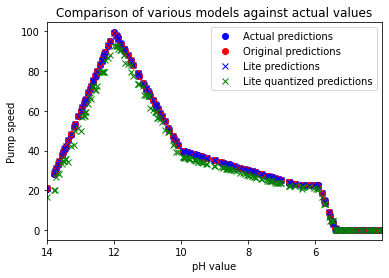

In [17]:
# Instantiate an interpreter for each model
model_no_quant = tf.lite.Interpreter(MODEL_NO_QUANT_TFLITE)
model = tf.lite.Interpreter(MODEL_TFLITE)

# Allocate memory for each model
model_no_quant.allocate_tensors()
model.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
model_no_quant_input = model_no_quant.tensor(model_no_quant.get_input_details()[0]["index"])
model_no_quant_output = model_no_quant.tensor(model_no_quant.get_output_details()[0]["index"])
model_input = model.tensor(model.get_input_details()[0]["index"])
model_output = model.tensor(model.get_output_details()[0]["index"])

# Create arrays to store the results
model_no_quant_predictions = np.empty(x_test.size)
model_predictions = np.empty(x_test.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(x_test.size):
  model_no_quant_input().fill(x_test[i])
  model_no_quant.invoke()
  model_no_quant_predictions[i] = model_no_quant_output()[0]

  model_input().fill(x_test[i])
  model.invoke()
  model_predictions[i] = model_output()[0]

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual predictions')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, model_no_quant_predictions, 'bx', label='Lite predictions')
plt.plot(x_test, model_predictions, 'gx', label='Lite quantized predictions')
plt.xlabel('pH value')
plt.ylabel('Pump speed')
plt.xlim(max(x_values), min(x_values))
plt.legend()
plt.show()

We can see from the graph that the predictions for the original model, the converted model, and the quantized model are all close enough to be indistinguishable. This means that our quantized model is ready to use!

## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [18]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

## Deploy to a Microcontroller

Follow the instructions in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) to deploy this model on a specific microcontroller.

**Reference Model:** If you have not modified this notebook, you can follow the instructions as is, to deploy the model. Refer to the [`hello_world/train/models`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/models) directory to access the models generated in this notebook.

**New Model:** If you have generated a new model, then update the values assigned to the variables defined in [`hello_world/model.cc`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/model.cc) with values displayed after running the following cell.

In [19]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00,
  0x24, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00, 0x7c, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x74, 0x07, 0x00, 0x00, 0x8c, 0x06, 0x00, 0x00,
  0xbc, 0x01, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00,
  0x17, 0x00, 0x00, 0x00, 0x84, 0x56, 0x00, 0x00, 0x80, 0x56, 0x00, 0x00,
  0x90, 0x55, 0x00, 0x00, 0xe0, 0x54, 0x00, 0x00, 0x68, 0x52, 0x00, 0x00,
  0xe0, 0x50, 0x00, 0x00, 0x68, 0x30, 0x00, 0x00, 0xe0, 0x2d, 0x00, 0x00,
  0x68, 0x0d, 0x00, 0x00, 0xe0, 0x0b, 0x00, 0x00, 0x68, 0x09, 0x00, 0x00,
  0xc0, 0x08, 0x00, 0x00, 0x40, 0x08, 0x00, 0x00, 0xb4, 0x07, 0x00, 0x00,
  0x4c, 0x56, 0x00, 0x00, 0x48, 0x56, 0x00, 0x00, 0x44, 0x56, 0x00, 0x00,
  0x40, 0x